<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from GitHub the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs_1.csv`, ..., `Kidney_CCcfs_5.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_EmbN2V_128.csv

Observe that the CCcfs file has been subdivided into 5 separate files for storage limitations on GitHub. 

### 3. Load the input files and process the tissue attributes

+ The label file (`Kidney_HELP.csv`) can be loaded via `read_csv`; its three-class labels (`E`, `aE`, `sNE`) are converted to two-class labels (`E`, `NE`); 

+ The tissue gene attributes are loaded and assembled via `feature_assemble_df` using the downloaded datafiles BIO, CCcfs subdivided into 5 subfiles (`'nchunks': 5`) and embedding. We do not apply missing values fixing (`'fixna': False`), while we do apply data scaling (`'normalize': 'std'`) to the BIO and CCcfs attributes.  

In [6]:
path = '../../data'
import os 
tissue='Brain'
import pandas as pd
import numpy as np
from HELPpy.preprocess.loaders import load_features
df_y = pd.read_csv(os.path.join(path,f"{tissue}_HELP.csv"), index_col=0)
df_y = df_y.replace({'aE': 0, 'sNE': 0, 'E': 1})
print(df_y.value_counts(normalize=False))
features = [os.path.join(path,f'{tissue}_BIO.csv'), 
            os.path.join(path,f'{tissue}_CCcfs.csv'), 
            os.path.join(path,f'{tissue}_EmbN2V_128.csv')]
df_X = load_features(filenames=features, 
                     fixnans=[False]*len(features),
                     normalizes=['std', 'std', None],
                     constrms=[True, False, False],
                     verbose=True, show_progress=True)
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X,df_y], axis=1)

label
0        16685
1         1246
dtype: int64


Brain_BIO.csv:   0%|          | 0/19318 [00:00<?, ?it/s]

[Brain_BIO] found 58547 Nan...
[Brain_BIO] No Nan fixing...
[Brain_BIO] found 2 Nan...
[Brain_BIO] Removing 2 constant features ...
[Brain_BIO] Normalization with std ...


Brain_CCcfs.csv:   0%|          | 0/19322 [00:00<?, ?it/s]

[Brain_CCcfs] found 6735590 Nan...
[Brain_CCcfs] No Nan fixing...
[Brain_CCcfs] found 3 Nan...
[Brain_CCcfs] No constant feature removal...
[Brain_CCcfs] Normalization with std ...


Brain_EmbN2V_128.csv:   0%|          | 0/19322 [00:00<?, ?it/s]

[Brain_EmbN2V_128] found 0 Nan...
[Brain_EmbN2V_128] No Nan fixing...
[Brain_EmbN2V_128] found 0 Nan...
[Brain_EmbN2V_128] No constant feature removal...
[Brain_EmbN2V_128] No normalization...


### 4. Estimate the performance of EGs prediction 

Instantiate the prediction model described in the HELP paper (soft-voting ensemble `VotingSplitClassifier` of `n_voters=10` classifiers) and estimate its performance via 5-fold cross-validation (`k_fold_cv` with `n_splits=5`). Then, print the obtained average performances (`df_scores`)... 

In [2]:
from HELPpy.models.prediction import VotingEnsembleLGBM, k_fold_cv
clf = VotingEnsembleLGBM(n_voters=13, learning_rate=0.1, n_estimators=200, boosting_type='gbdt', n_jobs=-1, random_state=42)
df_scores, scores, predictions = k_fold_cv(df_X, df_y, clf, n_splits=5, seed=0, show_progress=True, verbose=True)
df_scores

{'E': 0, 'NE': 1}
label
NE       15994
E         1242
Name: count, dtype: int64



5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.9156±0.0063
Accuracy,0.7964±0.0059
BA,0.8327±0.0059
Sensitivity,0.7902±0.0071
Specificity,0.8752±0.0154
MCC,0.3935±0.0065
CM,"[[1087, 155], [3355, 12639]]"


... and those in each fold (`scores`)

In [2]:
import numpy as np
y_pred = predictions['prediction'].values.ravel()
y_prob = predictions['probabilities'].values.ravel()
y_true = predictions['label'].values.ravel()
from sklearn.metrics import *
from imblearn.metrics import specificity_score

print(pd.DataFrame({'ROC-AUC' : [roc_auc_score(y_true, 1-y_prob, average='weighted')],
              'Accuracy' : [accuracy_score(y_true, y_pred)],
              'Sensitivity' : [specificity_score(y_true, y_pred)],
              'Specificity' : [recall_score(y_true, y_pred)],
              'BA' : [balanced_accuracy_score(y_true, y_pred)],
              'MCC' : [matthews_corrcoef(y_true, y_pred)],
              'CM': [confusion_matrix(y_true, y_pred)]
              }).T.to_latex())

print(confusion_matrix(y_true, y_pred))

NameError: name 'predictions' is not defined

In [4]:
scores

,ROC-AUC,Accuracy,BA,Sensitivity,Specificity,MCC,CM
index,,,,,,,
0,0.953869,0.87645,0.868606,0.877774,0.859438,0.501687,"[[214, 35], [391, 2808]]"
1,0.954145,0.868871,0.894016,0.864645,0.923387,0.516934,"[[229, 19], [433, 2766]]"
2,0.959863,0.86597,0.890593,0.861832,0.919355,0.510108,"[[228, 20], [442, 2757]]"
3,0.954039,0.874964,0.88428,0.873398,0.895161,0.514816,"[[222, 26], [405, 2794]]"
4,0.946393,0.871482,0.873336,0.871169,0.875502,0.500155,"[[218, 31], [412, 2786]]"


Show labels, predictions and their probabilities (`predictions`) and save them in a csv file

In [5]:
predictions

,label,prediction,probabilities
gene,,,
A4GNT,1,1,0.007120
AAAS,1,0,0.943234
AASDH,1,1,0.070971
ABCA2,1,1,0.234408
ABCA3,1,1,0.016606
...,...,...,...
ZSWIM7,1,1,0.092465
ZSWIM8,1,1,0.293142
ZXDA,1,1,0.012429


In [6]:
import os
savepath = "../data4rev"
predictions.to_csv(os.path.join(savepath, f"csEGs_{tissue}_EvsNE.csv"), index=True)

### 5. Compute TPR for ucsEGs and csEGs

Read the result files for ucsEGs (`ucsEG_Kidney.txt`) and csEGs (`csEGs_Kidney_EvsNE.csv`) already computed for the tissue, compute the TPRs (tpr) and show their bar plot. 

ucsEG Kidney TPR = 0.780 (46/59) ucsEG Kidney TPR =  0.897 (1114/1242)
ucsEG Lung TPR = 0.714 (20/28) ucsEG Lung TPR =  0.904 (1107/1224)
ucsEG Brain TPR = 0.585 (24/41) ucsEG Brain TPR =  0.884 (1091/1234)


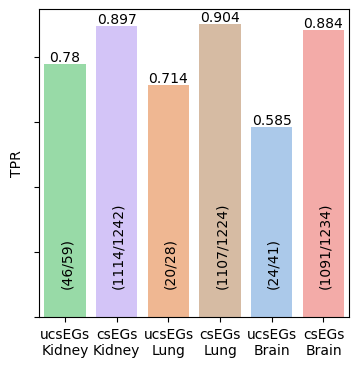

In [28]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
tissues = ['Kidney', 'Lung', 'Brain']
path = '../data'
labels = []
data = []
tpr = []
genes = {}
for tissue in tissues:
    #!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/ucsEG_{tissue}.txt
    ucsEGs = pd.read_csv(os.path.join(path,f"ucsEG_{tissue}.txt"), index_col=0, header=None).index.values
    #!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/csEGs_{tissue}_EvsNE.csv
    predictions = pd.read_csv(os.path.join(path,f"csEGs_{tissue}_EvsNE.csv"), index_col=0)
    indices = np.intersect1d(ucsEGs, predictions.index.values)
    preds = predictions.loc[indices]
    num1 = len(preds[preds['label'] == preds['prediction']])
    den1 = len(preds[preds['label'] == 0])
    den2 = len(predictions[predictions['label'] == 0])
    num2 = len(predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])])
    labels += [f"ucsEGs\n{tissue}", f"csEGs\n{tissue}"]
    data += [float(f"{num1 /den1:.3f}"), float(f"{num2 /den2:.3f}")]
    tpr += [f"{num1}/{den1}", f"{num2}/{den2}"]
    genes[f'ucsEGs_{tissue}_y'] = preds[preds['label'] == preds['prediction']].index.values
    genes[f'ucsEGs_{tissue}_n'] = preds[preds['label'] != preds['prediction']].index.values
    genes[f'csEGs_{tissue}_y'] = predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])].index.values
    genes[f'csEGs_{tissue}_n'] = predictions[(predictions['label'] == 0) & (predictions['label'] != predictions['prediction'])].index.values
    print(f"ucsEG {tissue} TPR = {num1 /den1:.3f} ({num1}/{den1}) ucsEG {tissue} TPR =  {num2/den2:.3f} ({num2}/{den2})")

f, ax = plt.subplots(figsize=(4, 4))
colors = ["#FF0B04", "#FF0B04", "#4374B3", "#4374B3","#ffffff", "#ffffff"]
# Set your custom color palette
customPalette = sns.color_palette("pastel", n_colors=6)
g = sns.barplot(y = data, x = labels, ax=ax, hue= data, palette = customPalette, orient='v', legend=False)
ax.set_ylabel('TPR')
ax.set(yticklabels=[])
for i,l,t in zip(range(len(tissues)*2),labels,tpr):
    ax.text(-0.1 + (i * 1.0), 0.1, f"({t})", rotation='vertical')
for i in ax.containers:
    ax.bar_label(i,)

In [36]:
s = []
for tissue in tissues:
    #!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/ucsEG_{tissue}.txt
    s += [set(pd.read_csv(os.path.join(path,f"ucsEG_{tissue}.txt"), index_col=0, header=None).index.values)]
s[1] & s[2], s[2] - (s[0] | s[1])

({'CDK2', 'CKS1B', 'DDX11', 'NCAPH2'},
 {'ACTB',
  'FAM50A',
  'FDXR',
  'FXN',
  'GABPB1',
  'GFER',
  'GNB1L',
  'HSCB',
  'KTI12',
  'NOPCHAP1',
  'NUP54',
  'PGS1',
  'RBM48',
  'RPL39',
  'RPP25L',
  'SERBP1',
  'SSB',
  'TAMM41',
  'TIMM9',
  'TOMM20',
  'URM1',
  'VHL',
  'VRK1'})

This code can be used to produce Fig 5(B) of the HELP paper by executing an iteration cycle for both `kidney` and `lung` tissues.

At the end, we print the list of ucs_EGs for the tissue.

In [39]:
tissue = 'Brain'
genes[f'ucsEGs_{tissue}_y'], genes[f'ucsEGs_{tissue}_n']

(array(['ACTB', 'CDK2', 'CHMP7', 'CKS1B', 'DDX11', 'EMC3', 'EXOSC1',
        'FAM50A', 'FDXR', 'GFER', 'NCAPH2', 'NUP54', 'RBM48', 'RPL39',
        'SERBP1', 'SNRPB2', 'SRSF10', 'SSB', 'TAF1D', 'TIMM9', 'TOMM20',
        'URM1', 'USP10', 'VRK1'], dtype=object),
 array(['ARF4', 'ARFRP1', 'CDK6', 'FERMT2', 'FXN', 'GABPB1', 'GNB1L',
        'HSCB', 'ITGAV', 'KTI12', 'NHLRC2', 'PGS1', 'PTK2', 'RPP25L',
        'TAMM41', 'VHL', 'WDR25'], dtype=object))